In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
import matplotlib as mpl
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux, align_fluxes_by_reference
from scipy.spatial import cKDTree
import pandas as pd
from multiprocessing.dummy import Pool
from tqdm import tqdm
from astropy.nddata import Cutout2D
import glob
import pickle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import warnings
import cv2
warnings.filterwarnings("ignore")

In [4]:
# Set location data
location = '/net/vdesk/data2/deklerk/GAAP_data'

field = '53.0_-28.0'

aperture_size = 5

In [5]:
with open(f'{location}/{field}/master_table_{aperture_size/5}".pkl', 'rb') as f:
    master_table = pickle.load(f)
with open(f'{location}/{field}/sigma_table_{aperture_size/5}".pkl', 'rb') as f:
    sigma = pickle.load(f)

In [6]:
hdul = fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits')
hdul.info()
cat = Table(hdul[1].data)

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

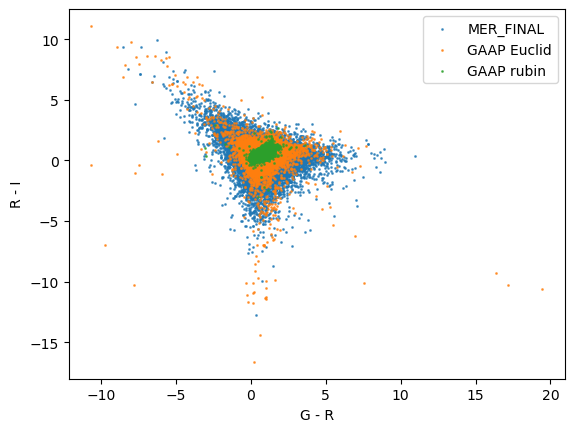

In [13]:
plt.scatter(-2.5*np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER']/ cat['FLUX_R_EXT_DECAM_2FWHM_APER']), -2.5*np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER']/ cat['FLUX_I_EXT_DECAM_2FWHM_APER']), s=1, alpha=0.7)
plt.scatter(-2.5*np.log10(master_table['flux_DES-G']/ master_table['flux_DES-R']), -2.5*np.log10(master_table['flux_DES-R']/ master_table['flux_DES-I']), s=1, alpha=0.7)
plt.scatter(-2.5*np.log10(master_table['flux_g']/ master_table['flux_r']), -2.5*np.log10(master_table['flux_r']/ master_table['flux_i']), s=1, alpha=0.7)
plt.xlabel('G - R')
plt.ylabel('R - I')
plt.legend(['MER_FINAL', 'GAAP Euclid', 'GAAP rubin'])
plt.show()

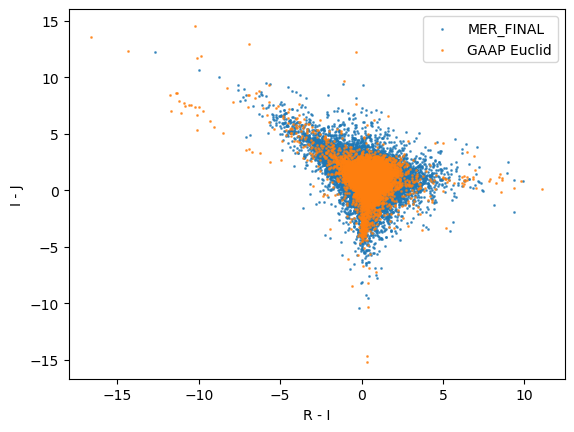

In [19]:
plt.scatter(-2.5*np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER']/ cat['FLUX_I_EXT_DECAM_2FWHM_APER']), -2.5*np.log10(cat['FLUX_I_EXT_DECAM_2FWHM_APER']/ cat['FLUX_J_2FWHM_APER']), s=1, alpha=0.7)
plt.scatter(-2.5*np.log10(master_table['flux_DES-R']/ master_table['flux_DES-I']), -2.5*np.log10(master_table['flux_DES-I']/ master_table['flux_NIR-J']), s=1, alpha=0.7)
plt.xlabel('R - I')
plt.ylabel('I - J')
plt.legend(['MER_FINAL', 'GAAP Euclid'])
plt.show()

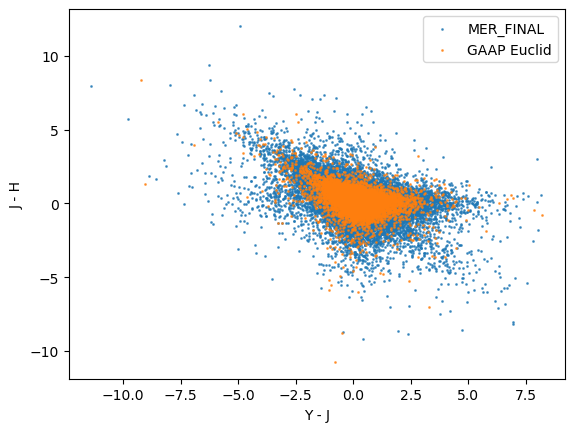

In [20]:
plt.scatter(-2.5*np.log10(cat['FLUX_Y_2FWHM_APER']/ cat['FLUX_J_2FWHM_APER']), -2.5*np.log10(cat['FLUX_J_2FWHM_APER']/ cat['FLUX_H_2FWHM_APER']), s=1, alpha=0.7)
plt.scatter(-2.5*np.log10(master_table['flux_NIR-Y']/ master_table['flux_NIR-J']), -2.5*np.log10(master_table['flux_NIR-J']/ master_table['flux_NIR-H']), s=1, alpha=0.7)
plt.xlabel('Y - J')
plt.ylabel('J - H')
plt.legend(['MER_FINAL', 'GAAP Euclid'])
plt.show()